# 05: Results Comparison & Conclusions

This notebook consolidates all results and provides final analysis:
- **Load all results** from baseline models, fairness analysis, and mitigation
- **Compare baseline vs. mitigated models** across all protected attributes
- **Analyze fairness-accuracy tradeoffs** comprehensively
- **Visualize comprehensive results** with before/after comparisons
- **Document key findings and conclusions**
- **Generate final summary metrics** and recommendations

**Approach:** We load all saved results, create comprehensive visualizations showing improvements, and provide final analysis of which mitigation techniques work best for different fairness concerns.


In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Install packages (for Google Colab)
if IN_COLAB:
    %pip install scikit-learn matplotlib seaborn fairlearn pandas numpy -q

# Imports
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# Note: sklearn.metrics imported but not directly used here (metrics loaded from JSON files)
# Kept for potential future use or consistency with other notebooks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("=" * 60)
print("RESULTS COMPARISON & CONCLUSIONS")
print("=" * 60)
print("Setup complete!")


RESULTS COMPARISON & CONCLUSIONS
Setup complete!


## 1. Load All Results

Load all saved results from previous notebooks:
- Baseline model metrics
- Fairness analysis results
- Mitigation results and comparisons
- Protected attribute data


In [3]:
# Determine data directory (works for both local and Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    possible_paths = [
        Path('/content/drive/MyDrive/6.3950_project/processed_data'),
        Path('/content/drive/Shareddrives/Insurance Fairness/processed_data'),
        Path('/content/drive/MyDrive/insurance-fairness/results'),
        Path('../results')
    ]
else:
    possible_paths = [
        Path('../results'),
        Path('./results')
    ]

results_dir = None
for path in possible_paths:
    if path.exists() and (path / 'all_models_comparison.json').exists():
        results_dir = path
        break

if results_dir is None:
    error_msg = (
        "Could not find results directory. Please run notebooks 01-04 first.\n"
        f"Tried paths: {', '.join([str(p) for p in possible_paths])}"
    )
    raise FileNotFoundError(error_msg)

print(f"Loading results from: {results_dir}")

# Load all comparison results
print("\nLoading comparison data...")
with open(results_dir / 'all_models_comparison.json', 'r') as f:
    all_models_comparison = json.load(f)

with open(results_dir / 'mitigation_comparison.csv', 'r') as f:
    mitigation_comparison_df = pd.read_csv(f)

with open(results_dir / 'baseline_fairness_analysis.json', 'r') as f:
    baseline_fairness = json.load(f)

# Load metadata
with open(results_dir / 'preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)
    protected_attributes_list = metadata.get('protected_attributes', [])

# Load test data for additional analysis (if needed for future extensions)
# Note: Currently not used in this notebook but loaded for potential future use
print("Loading test data...")
with open(results_dir / 'X_test.pkl', 'rb') as f: X_test = pickle.load(f)
with open(results_dir / 'y_test.pkl', 'rb') as f: y_test = pickle.load(f)
with open(results_dir / 'protected_test.pkl', 'rb') as f: protected_test = pickle.load(f)

# Validate loaded data
print("\nValidating loaded data...")
if not isinstance(all_models_comparison, dict):
    raise TypeError("all_models_comparison should be a dictionary")
if len(all_models_comparison) == 0:
    raise ValueError("No models found in comparison data")

if not isinstance(mitigation_comparison_df, pd.DataFrame):
    raise TypeError("mitigation_comparison_df should be a pandas DataFrame")
if len(mitigation_comparison_df) == 0:
    raise ValueError("No comparison data found in mitigation_comparison_df")

if not isinstance(protected_attributes_list, list):
    raise TypeError("protected_attributes_list should be a list")
if len(protected_attributes_list) == 0:
    print("Warning: No protected attributes found in metadata")

# Validate required columns exist
required_cols = ['Approach', 'Accuracy', 'DP Difference', 'EO Difference']
missing_cols = [col for col in required_cols if col not in mitigation_comparison_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in mitigation_comparison_df: {missing_cols}")

print(f"\nData loaded successfully!")
print(f"   Protected attributes: {', '.join(protected_attributes_list) if protected_attributes_list else 'None'}")
print(f"   Test set size: {len(y_test):,} samples")
print(f"   Models compared: {len(all_models_comparison)}")
print(f"   Mitigation techniques: {len(mitigation_comparison_df) - 2}")  # Excluding baselines


Loading results from: ..\results

Loading comparison data...
Loading test data...

Validating loaded data...

Data loaded successfully!
   Protected attributes: Gender, EmploymentStatus, Education, Marital Status, Location Code, State, Income
   Test set size: 1,371 samples
   Models compared: 8
   Mitigation techniques: 6


## 2. Helper Functions for Visualization

Define functions to create comprehensive comparison visualizations.


In [4]:
def compare_models_before_after(baseline_metrics, mitigated_metrics, attribute_name, 
                                mitigation_technique="Mitigation"):
    """
    Create before/after comparison visualization for a single attribute.
    
    Parameters:
    -----------
    baseline_metrics : dict
        Metrics dictionary for baseline model
    mitigated_metrics : dict
        Metrics dictionary for mitigated model
    attribute_name : str
        Name of the protected attribute
    mitigation_technique : str
        Name of the mitigation technique used
    """
    metrics_to_plot = {
        'Accuracy': ('accuracy', 'higher'),
        'DP Difference': ('demographic_parity_difference', 'lower'),
        'EO Difference': ('equalized_odds_difference', 'lower'),
        'F1-Score': ('f1', 'higher')
    }
    
    baseline_vals = []
    mitigated_vals = []
    valid_indices = []  # Track which metrics are valid
    
    for idx, (key, _) in enumerate(metrics_to_plot.values()):
        baseline_val = baseline_metrics.get(key, np.nan)
        mitigated_val = mitigated_metrics.get(key, np.nan)
        
        # Only include if both values are valid (not NaN)
        if not (np.isnan(baseline_val) or np.isnan(mitigated_val)):
            baseline_vals.append(baseline_val)
            mitigated_vals.append(mitigated_val)
            valid_indices.append(idx)
    
    # Filter metrics_to_plot to only valid ones
    if len(valid_indices) == 0:
        print(f"Warning: No valid metrics found for {attribute_name}")
        return
    
    metrics_list = list(metrics_to_plot.items())
    metrics_to_plot_filtered = {k: v for idx, (k, v) in enumerate(metrics_list) if idx in valid_indices}
    
    # Now create the plot with the valid data
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(baseline_vals))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline',
                   color='#ff5722', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, mitigated_vals, width, label=mitigation_technique,
                   color='#4caf50', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
    ax.set_title(f'{attribute_name} - Before vs After Mitigation', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{name}\n({dir})' for name, (_, dir) in metrics_to_plot_filtered.items()],
                       fontsize=10)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom' if height >= 0 else 'top',
                       fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print improvement summary
    print(f"\n{attribute_name} - Improvement Summary:")
    for metric_name, (key, direction) in metrics_to_plot_filtered.items():
        baseline_val = baseline_metrics.get(key, np.nan)
        mitigated_val = mitigated_metrics.get(key, np.nan)
        if not (np.isnan(baseline_val) or np.isnan(mitigated_val)) and baseline_val != 0:
            if direction == 'lower':
                improvement = baseline_val - mitigated_val
                pct = (improvement / baseline_val * 100)
            else:
                improvement = mitigated_val - baseline_val
                pct = (improvement / baseline_val * 100)
            
            print(f"   {metric_name}: {baseline_val:.4f} → {mitigated_val:.4f} "
                  f"({improvement:+.4f}, {pct:+.1f}%)")


def create_comprehensive_comparison_table(all_results_dict, primary_attribute=None):
    """
    Create a comprehensive comparison table across all models and attributes.
    
    Parameters:
    -----------
    all_results_dict : dict
        Dictionary with structure: {model_name: {attribute: {metrics}}}
    primary_attribute : str, optional
        If provided, focus on this attribute; otherwise show all
    """
    rows = []
    
    for model_name, attr_results in all_results_dict.items():
        if primary_attribute and primary_attribute in attr_results:
            metrics = attr_results[primary_attribute]
            rows.append({
                'Model': model_name,
                'Attribute': primary_attribute,
                'Accuracy': metrics.get('accuracy', np.nan),
                'Precision': metrics.get('precision', np.nan),
                'Recall': metrics.get('recall', np.nan),
                'F1': metrics.get('f1', np.nan),
                'ROC-AUC': metrics.get('roc_auc', np.nan),
                'DP Diff': metrics.get('demographic_parity_difference', np.nan),
                'EO Diff': metrics.get('equalized_odds_difference', np.nan),
                'Precision Diff': metrics.get('precision_difference', np.nan)
            })
        elif not primary_attribute:
            # Include all attributes
            for attr_name, metrics in attr_results.items():
                rows.append({
                    'Model': model_name,
                    'Attribute': attr_name,
                    'Accuracy': metrics.get('accuracy', np.nan),
                    'Precision': metrics.get('precision', np.nan),
                    'Recall': metrics.get('recall', np.nan),
                    'F1': metrics.get('f1', np.nan),
                    'ROC-AUC': metrics.get('roc_auc', np.nan),
                    'DP Diff': metrics.get('demographic_parity_difference', np.nan),
                    'EO Diff': metrics.get('equalized_odds_difference', np.nan),
                    'Precision Diff': metrics.get('precision_difference', np.nan)
                })
    
    return pd.DataFrame(rows)


def safe_percent_change(baseline_mean, mitigated_mean):
    """Calculate percentage change with division-by-zero protection."""
    if baseline_mean is None or mitigated_mean is None:
        return None
    if baseline_mean == 0:
        return None  # Cannot calculate percentage when baseline is 0
    return float((mitigated_mean - baseline_mean) / baseline_mean * 100)


def safe_reduction_pct(baseline_mean, mitigated_mean):
    """Calculate reduction percentage with division-by-zero protection."""
    if baseline_mean is None or mitigated_mean is None:
        return None
    if baseline_mean == 0:
        return None  # Cannot calculate percentage when baseline is 0
    return float((baseline_mean - mitigated_mean) / baseline_mean * 100)


print("Helper functions defined!")


Helper functions defined!


## 3. Overall Comparison Summary

Create a high-level summary comparing all models and mitigation techniques.


In [5]:
print("=" * 60)
print("OVERALL COMPARISON SUMMARY")
print("=" * 60)

# Check if DataFrame is empty
if len(mitigation_comparison_df) == 0:
    print("Warning: No comparison data available. Skipping summary.")
else:
    # Determine primary attribute (use first protected attribute or EmploymentStatus as default)
    primary_attr = protected_attributes_list[0] if protected_attributes_list else "EmploymentStatus"
    
    # Display the mitigation comparison table (for primary attribute)
    print(f"\nMitigation Comparison (Primary Attribute: {primary_attr})")
    print("=" * 100)
    print(mitigation_comparison_df.round(4).to_string(index=False))
    
    # Identify best models
    print("\n" + "=" * 100)
    print("KEY FINDINGS")
    print("=" * 100)
    
    # Best accuracy
    if 'Accuracy' in mitigation_comparison_df.columns and not mitigation_comparison_df['Accuracy'].isna().all():
        best_acc_idx = mitigation_comparison_df['Accuracy'].idxmax()
        best_acc = mitigation_comparison_df.loc[best_acc_idx, 'Accuracy']
        best_acc_model = mitigation_comparison_df.loc[best_acc_idx, 'Approach']
        print(f"\nBest Accuracy: {best_acc:.4f} ({best_acc_model})")
    else:
        print("\nWarning: Could not determine best accuracy (missing or all NaN)")
        best_acc = None
        best_acc_model = None
    
    # Best DP (lowest difference)
    if 'DP Difference' in mitigation_comparison_df.columns and not mitigation_comparison_df['DP Difference'].isna().all():
        best_dp_idx = mitigation_comparison_df['DP Difference'].idxmin()
        best_dp = mitigation_comparison_df.loc[best_dp_idx, 'DP Difference']
        best_dp_model = mitigation_comparison_df.loc[best_dp_idx, 'Approach']
        print(f"Best Demographic Parity (lowest): {best_dp:.4f} ({best_dp_model})")
    else:
        print("Warning: Could not determine best DP (missing or all NaN)")
        best_dp = None
        best_dp_model = None
    
    # Best EO (lowest difference)
    if 'EO Difference' in mitigation_comparison_df.columns and not mitigation_comparison_df['EO Difference'].isna().all():
        best_eo_idx = mitigation_comparison_df['EO Difference'].idxmin()
        best_eo = mitigation_comparison_df.loc[best_eo_idx, 'EO Difference']
        best_eo_model = mitigation_comparison_df.loc[best_eo_idx, 'Approach']
        print(f"Best Equalized Odds (lowest): {best_eo:.4f} ({best_eo_model})")
    else:
        print("Warning: Could not determine best EO (missing or all NaN)")
        best_eo = None
        best_eo_model = None
    
    # Calculate improvements from baseline
    lr_baseline_mask = mitigation_comparison_df['Approach'] == 'LR_Baseline'
    rf_baseline_mask = mitigation_comparison_df['Approach'] == 'RF_Baseline'
    
    if lr_baseline_mask.any() and rf_baseline_mask.any():
        lr_baseline_idx = mitigation_comparison_df[lr_baseline_mask].index[0]
        rf_baseline_idx = mitigation_comparison_df[rf_baseline_mask].index[0]
        
        lr_baseline_dp = mitigation_comparison_df.loc[lr_baseline_idx, 'DP Difference']
        rf_baseline_dp = mitigation_comparison_df.loc[rf_baseline_idx, 'DP Difference']
        
        print(f"\nImprovement from Baselines:")
        print(f"   LR Baseline DP: {lr_baseline_dp:.4f}")
        if best_dp is not None:
            print(f"   Best Mitigated DP: {best_dp:.4f}")
            improvement_abs = lr_baseline_dp - best_dp
            if lr_baseline_dp != 0:
                improvement_pct = (improvement_abs / lr_baseline_dp) * 100
                print(f"   Improvement: {improvement_abs:.4f} ({improvement_pct:.1f}% reduction)")
            else:
                print(f"   Improvement: {improvement_abs:.4f} (baseline was 0)")
        
        print(f"\n   RF Baseline DP: {rf_baseline_dp:.4f}")
        if best_dp is not None:
            print(f"   Best Mitigated DP: {best_dp:.4f}")
            improvement_abs = rf_baseline_dp - best_dp
            if rf_baseline_dp != 0:
                improvement_pct = (improvement_abs / rf_baseline_dp) * 100
                print(f"   Improvement: {improvement_abs:.4f} ({improvement_pct:.1f}% reduction)")
            else:
                print(f"   Improvement: {improvement_abs:.4f} (baseline was 0)")
    else:
        print("\nWarning: Baseline models not found in comparison data")


OVERALL COMPARISON SUMMARY

Mitigation Comparison (Primary Attribute: Gender)
                 Approach  Accuracy  Precision  Recall  F1-Score  ROC-AUC  DP Difference  EO Difference  Precision Diff
              LR_Baseline    0.7119     0.2990  0.7551    0.4284   0.8044         0.8609         0.9038          0.5293
              RF_Baseline    0.9161     0.6311  0.9949    0.7723   0.9907         0.7989         0.5936          0.5745
    LR_ThresholdOptimizer    0.8505     0.3043  0.0357    0.0639   0.8044         0.0231         0.0513          0.3333
    RF_ThresholdOptimizer    0.8818     0.6491  0.3776    0.4774   0.9907         0.1246         0.7576          0.7143
ExpGrad_DemographicParity    0.6951     0.2489  0.5612    0.3448   0.8044         0.0481         0.4242          0.4654
    ExpGrad_EqualizedOdds    0.7629     0.2952  0.4745    0.3640   0.8044         0.2475         0.1494          0.5735
            LR_Reweighted    0.6652     0.2689  0.7806    0.4000   0.7621         

## 4. Before/After Comparisons by Attribute

Show detailed before/after comparisons for each protected attribute, highlighting which mitigation techniques work best for each.


BEFORE/AFTER COMPARISONS BY ATTRIBUTE

ATTRIBUTE: Gender

Logistic Regression Baseline vs RF_ThresholdOptimizer


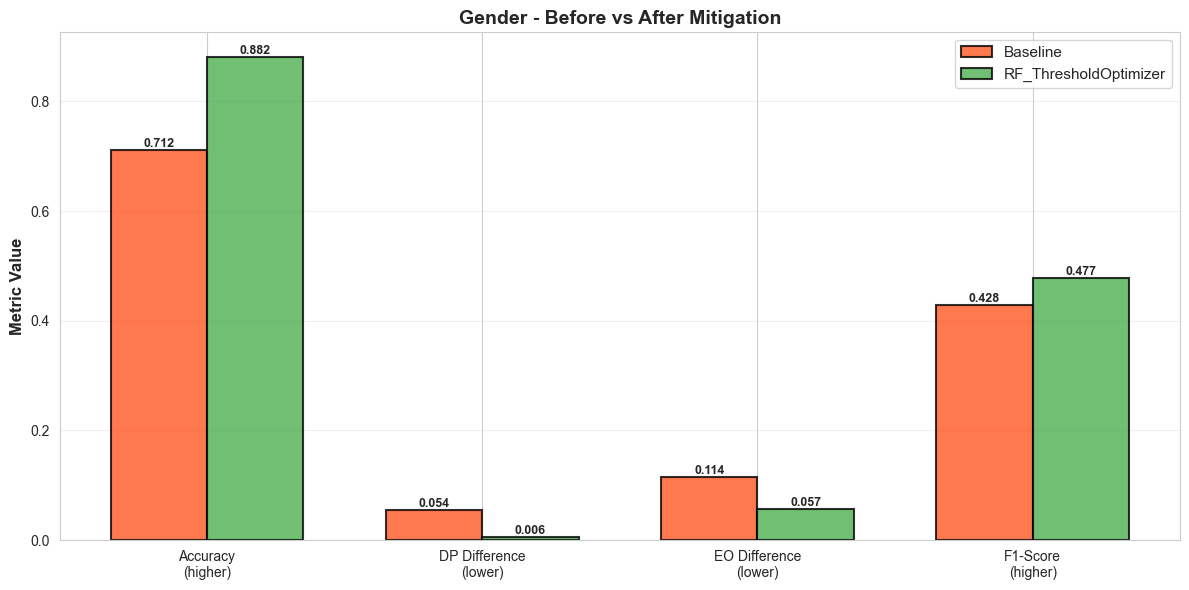


Gender - Improvement Summary:
   Accuracy: 0.7119 → 0.8818 (+0.1699, +23.9%)
   DP Difference: 0.0544 → 0.0057 (+0.0487, +89.5%)
   EO Difference: 0.1145 → 0.0572 (+0.0572, +50.0%)
   F1-Score: 0.4284 → 0.4774 (+0.0491, +11.5%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.0544
      EO Difference: 0.1145

   Best Mitigated (RF_ThresholdOptimizer):
      Accuracy: 0.8818
      DP Difference: 0.0057
      EO Difference: 0.0572

   Improvements:
      DP: +0.0487 (+89.5%)
      EO: +0.0572 (+50.0%)
      Accuracy: +0.1699 (+23.9%)

ATTRIBUTE: EmploymentStatus

Logistic Regression Baseline vs LR_ThresholdOptimizer


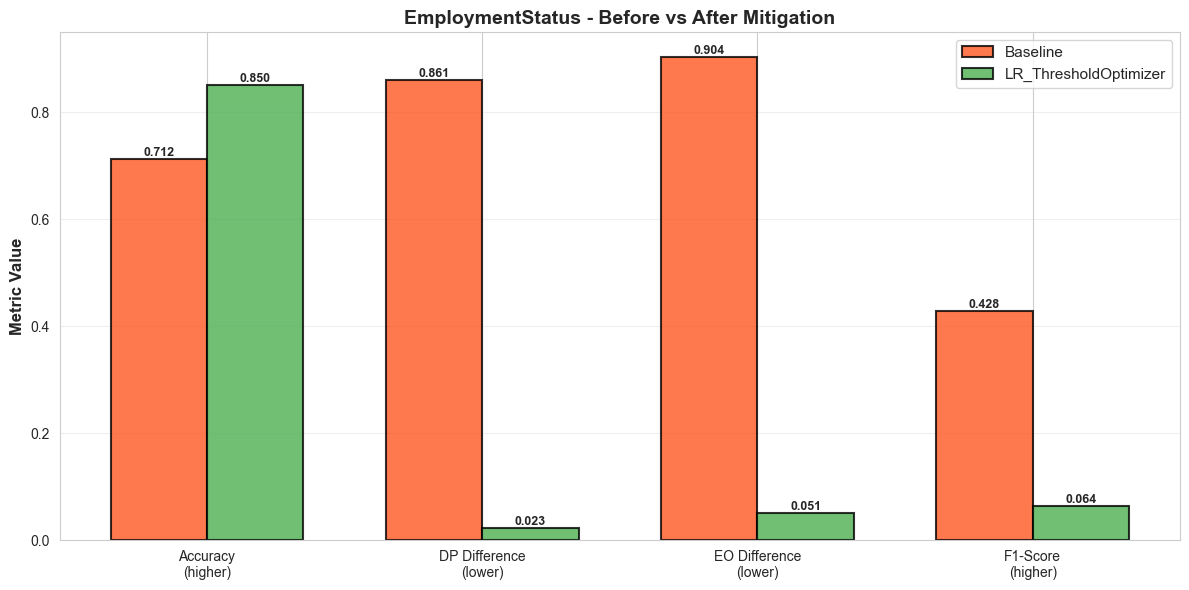


EmploymentStatus - Improvement Summary:
   Accuracy: 0.7119 → 0.8505 (+0.1386, +19.5%)
   DP Difference: 0.8609 → 0.0231 (+0.8377, +97.3%)
   EO Difference: 0.9038 → 0.0513 (+0.8526, +94.3%)
   F1-Score: 0.4284 → 0.0639 (-0.3644, -85.1%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.8609
      EO Difference: 0.9038

   Best Mitigated (LR_ThresholdOptimizer):
      Accuracy: 0.8505
      DP Difference: 0.0231
      EO Difference: 0.0513

   Improvements:
      DP: +0.8377 (+97.3%)
      EO: +0.8526 (+94.3%)
      Accuracy: +0.1386 (+19.5%)

ATTRIBUTE: Education

Logistic Regression Baseline vs RF_ThresholdOptimizer


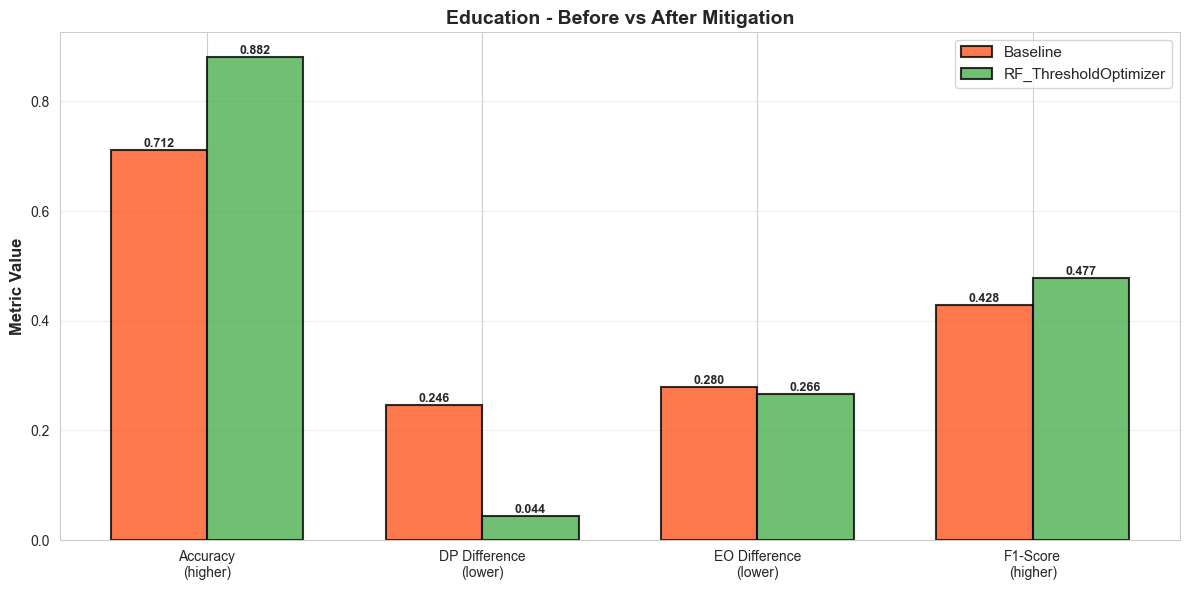


Education - Improvement Summary:
   Accuracy: 0.7119 → 0.8818 (+0.1699, +23.9%)
   DP Difference: 0.2462 → 0.0440 (+0.2022, +82.1%)
   EO Difference: 0.2797 → 0.2660 (+0.0137, +4.9%)
   F1-Score: 0.4284 → 0.4774 (+0.0491, +11.5%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.2462
      EO Difference: 0.2797

   Best Mitigated (RF_ThresholdOptimizer):
      Accuracy: 0.8818
      DP Difference: 0.0440
      EO Difference: 0.2660

   Improvements:
      DP: +0.2022 (+82.1%)
      EO: +0.0137 (+4.9%)
      Accuracy: +0.1699 (+23.9%)

ATTRIBUTE: Marital Status

Logistic Regression Baseline vs LR_ThresholdOptimizer


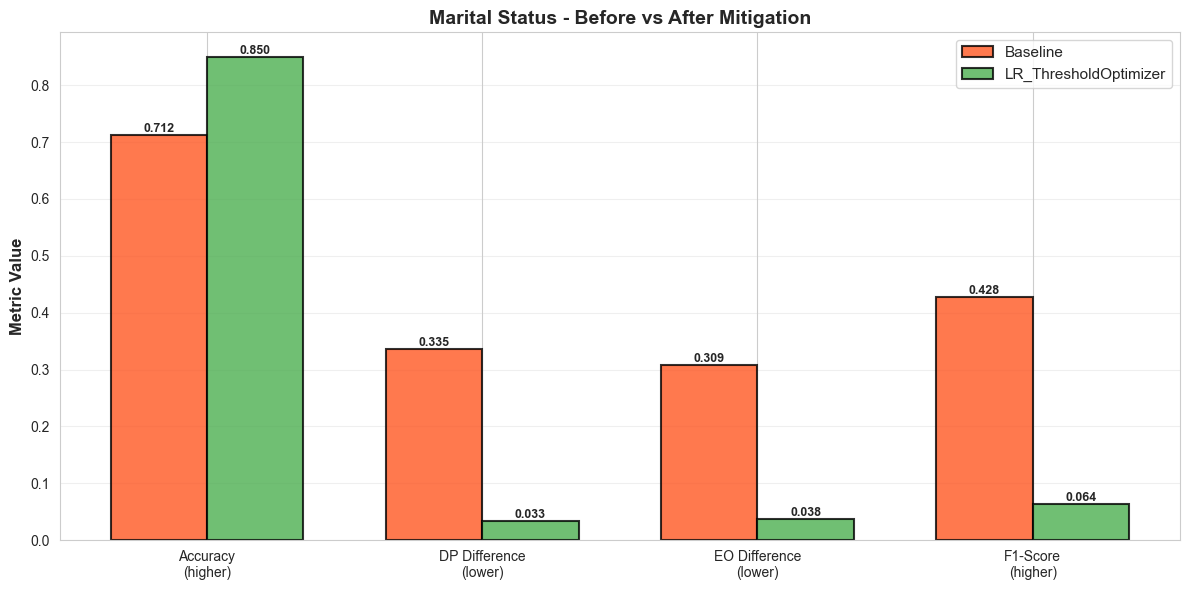


Marital Status - Improvement Summary:
   Accuracy: 0.7119 → 0.8505 (+0.1386, +19.5%)
   DP Difference: 0.3353 → 0.0335 (+0.3019, +90.0%)
   EO Difference: 0.3088 → 0.0377 (+0.2711, +87.8%)
   F1-Score: 0.4284 → 0.0639 (-0.3644, -85.1%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.3353
      EO Difference: 0.3088

   Best Mitigated (LR_ThresholdOptimizer):
      Accuracy: 0.8505
      DP Difference: 0.0335
      EO Difference: 0.0377

   Improvements:
      DP: +0.3019 (+90.0%)
      EO: +0.2711 (+87.8%)
      Accuracy: +0.1386 (+19.5%)

ATTRIBUTE: Location Code

Logistic Regression Baseline vs LR_ThresholdOptimizer


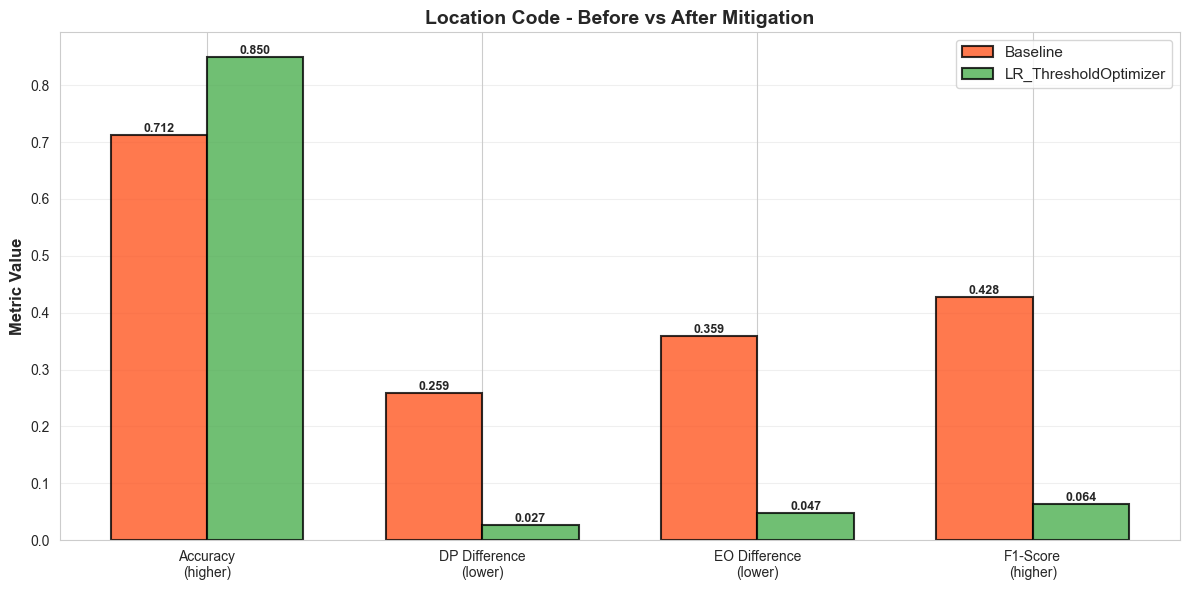


Location Code - Improvement Summary:
   Accuracy: 0.7119 → 0.8505 (+0.1386, +19.5%)
   DP Difference: 0.2593 → 0.0265 (+0.2327, +89.8%)
   EO Difference: 0.3589 → 0.0470 (+0.3119, +86.9%)
   F1-Score: 0.4284 → 0.0639 (-0.3644, -85.1%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.2593
      EO Difference: 0.3589

   Best Mitigated (LR_ThresholdOptimizer):
      Accuracy: 0.8505
      DP Difference: 0.0265
      EO Difference: 0.0470

   Improvements:
      DP: +0.2327 (+89.8%)
      EO: +0.3119 (+86.9%)
      Accuracy: +0.1386 (+19.5%)

ATTRIBUTE: State

Logistic Regression Baseline vs RF_ThresholdOptimizer


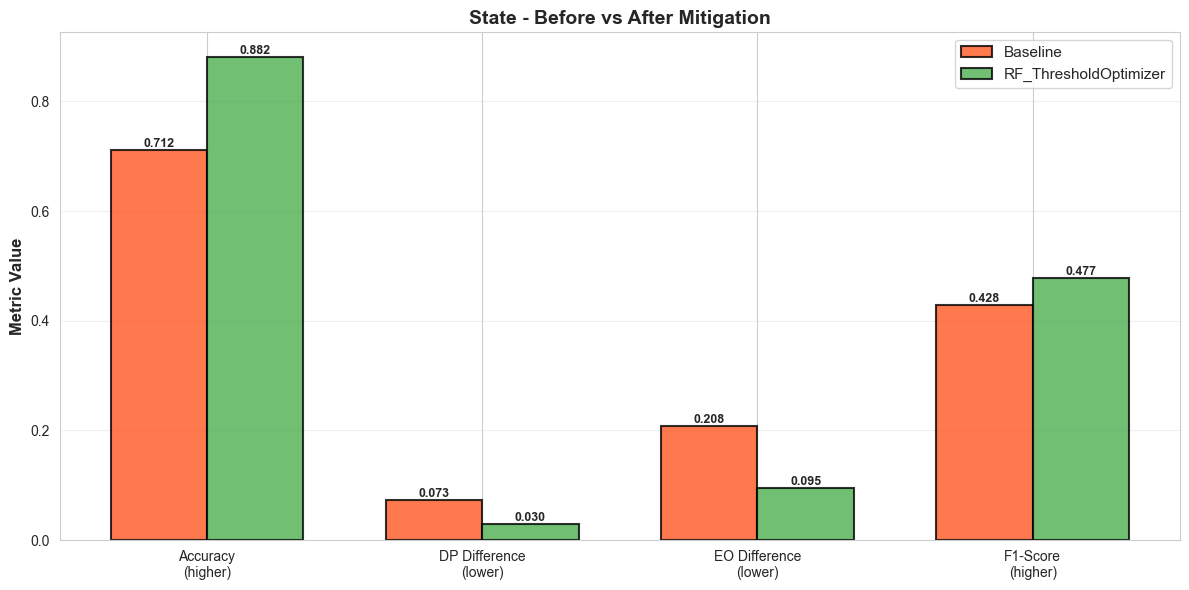


State - Improvement Summary:
   Accuracy: 0.7119 → 0.8818 (+0.1699, +23.9%)
   DP Difference: 0.0729 → 0.0295 (+0.0434, +59.6%)
   EO Difference: 0.2078 → 0.0954 (+0.1124, +54.1%)
   F1-Score: 0.4284 → 0.4774 (+0.0491, +11.5%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.0729
      EO Difference: 0.2078

   Best Mitigated (RF_ThresholdOptimizer):
      Accuracy: 0.8818
      DP Difference: 0.0295
      EO Difference: 0.0954

   Improvements:
      DP: +0.0434 (+59.6%)
      EO: +0.1124 (+54.1%)
      Accuracy: +0.1699 (+23.9%)

ATTRIBUTE: Income

Logistic Regression Baseline vs LR_ThresholdOptimizer


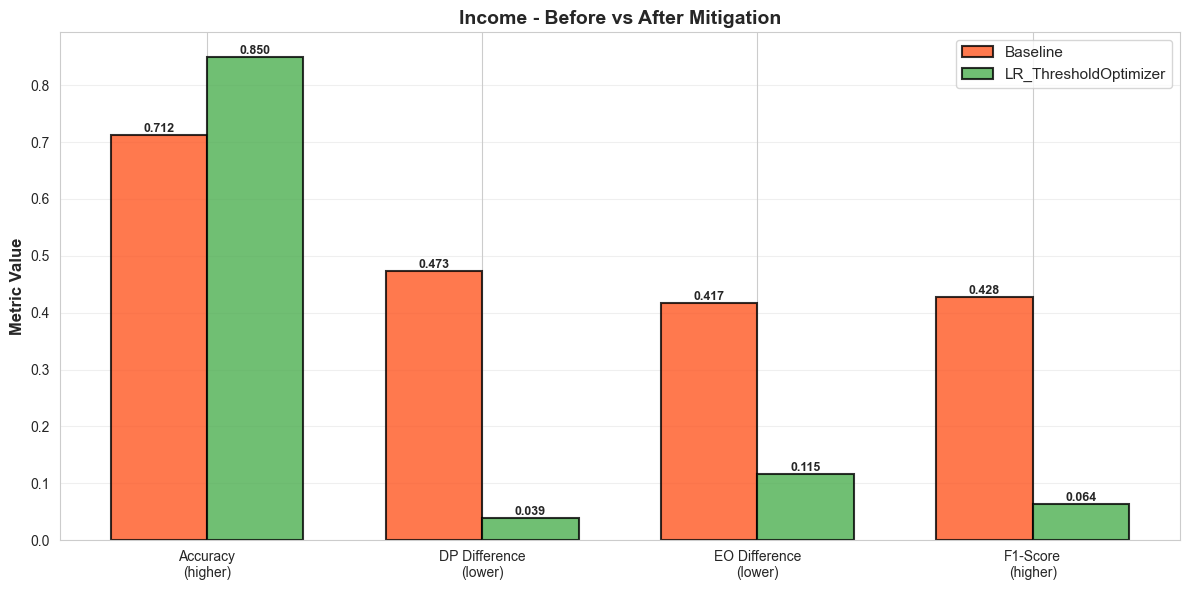


Income - Improvement Summary:
   Accuracy: 0.7119 → 0.8505 (+0.1386, +19.5%)
   DP Difference: 0.4725 → 0.0390 (+0.4335, +91.7%)
   EO Difference: 0.4165 → 0.1154 (+0.3011, +72.3%)
   F1-Score: 0.4284 → 0.0639 (-0.3644, -85.1%)

   Baseline Metrics:
      Accuracy: 0.7119
      DP Difference: 0.4725
      EO Difference: 0.4165

   Best Mitigated (LR_ThresholdOptimizer):
      Accuracy: 0.8505
      DP Difference: 0.0390
      EO Difference: 0.1154

   Improvements:
      DP: +0.4335 (+91.7%)
      EO: +0.3011 (+72.3%)
      Accuracy: +0.1386 (+19.5%)


In [6]:
print("=" * 60)
print("BEFORE/AFTER COMPARISONS BY ATTRIBUTE")
print("=" * 60)

# Check if we have protected attributes
if not protected_attributes_list:
    print("Warning: No protected attributes found. Skipping attribute comparisons.")
else:
    # Get baseline models
    lr_baseline_results = all_models_comparison.get('LR_Baseline', {})
    rf_baseline_results = all_models_comparison.get('RF_Baseline', {})
    
    # Get best mitigated models for each attribute
    # We'll compare against the best mitigation technique for each attribute
    
    for attr in protected_attributes_list:
        if attr not in lr_baseline_results:
            continue
        
        print(f"\n{'='*60}")
        print(f"ATTRIBUTE: {attr}")
        print(f"{'='*60}")
        
        # Get baseline metrics
        lr_baseline_metrics = lr_baseline_results.get(attr, {})
        rf_baseline_metrics = rf_baseline_results.get(attr, {})
        
        # Find best mitigated model for this attribute
        best_mitigated_model = None
        best_mitigated_metrics = None
        best_dp = float('inf')
        
        for model_name, attr_results in all_models_comparison.items():
            if 'Baseline' in model_name:
                continue
            if attr in attr_results:
                metrics = attr_results[attr]
                dp_diff = metrics.get('demographic_parity_difference', float('inf'))
                if dp_diff < best_dp:
                    best_dp = dp_diff
                    best_mitigated_model = model_name
                    best_mitigated_metrics = metrics
        
        if best_mitigated_model and best_mitigated_metrics:
            # Compare LR baseline vs best mitigated
            print(f"\nLogistic Regression Baseline vs {best_mitigated_model}")
            compare_models_before_after(
                lr_baseline_metrics, 
                best_mitigated_metrics, 
                attr,
                best_mitigated_model
            )
            
            # Show summary statistics
            print(f"\n   Baseline Metrics:")
            print(f"      Accuracy: {lr_baseline_metrics.get('accuracy', 0):.4f}")
            print(f"      DP Difference: {lr_baseline_metrics.get('demographic_parity_difference', 0):.4f}")
            print(f"      EO Difference: {lr_baseline_metrics.get('equalized_odds_difference', 0):.4f}")
            
            print(f"\n   Best Mitigated ({best_mitigated_model}):")
            print(f"      Accuracy: {best_mitigated_metrics.get('accuracy', 0):.4f}")
            print(f"      DP Difference: {best_mitigated_metrics.get('demographic_parity_difference', 0):.4f}")
            print(f"      EO Difference: {best_mitigated_metrics.get('equalized_odds_difference', 0):.4f}")
            
            # Calculate improvements
            dp_improvement = lr_baseline_metrics.get('demographic_parity_difference', 0) - \
                            best_mitigated_metrics.get('demographic_parity_difference', 0)
            eo_improvement = lr_baseline_metrics.get('equalized_odds_difference', 0) - \
                            best_mitigated_metrics.get('equalized_odds_difference', 0)
            acc_change = best_mitigated_metrics.get('accuracy', 0) - \
                        lr_baseline_metrics.get('accuracy', 0)
            
            # Calculate percentage improvements with division-by-zero protection
            baseline_dp = lr_baseline_metrics.get('demographic_parity_difference', 0)
            baseline_eo = lr_baseline_metrics.get('equalized_odds_difference', 0)
            baseline_acc = lr_baseline_metrics.get('accuracy', 0)
            
            print(f"\n   Improvements:")
            if baseline_dp != 0:
                dp_pct = (dp_improvement / baseline_dp) * 100
                print(f"      DP: {dp_improvement:+.4f} ({dp_pct:+.1f}%)")
            else:
                print(f"      DP: {dp_improvement:+.4f} (baseline was 0)")
            
            if baseline_eo != 0:
                eo_pct = (eo_improvement / baseline_eo) * 100
                print(f"      EO: {eo_improvement:+.4f} ({eo_pct:+.1f}%)")
            else:
                print(f"      EO: {eo_improvement:+.4f} (baseline was 0)")
            
            if baseline_acc != 0:
                acc_pct = (acc_change / baseline_acc) * 100
                print(f"      Accuracy: {acc_change:+.4f} ({acc_pct:+.1f}%)")
            else:
                print(f"      Accuracy: {acc_change:+.4f} (baseline was 0)")
        else:
            print(f"   Warning: No mitigated models found for {attr}")


## 5. Comprehensive Fairness-Accuracy Tradeoff Visualization

Create comprehensive visualizations showing the tradeoff between accuracy and fairness for all models.


FAIRNESS-ACCURACY TRADEOFF VISUALIZATION


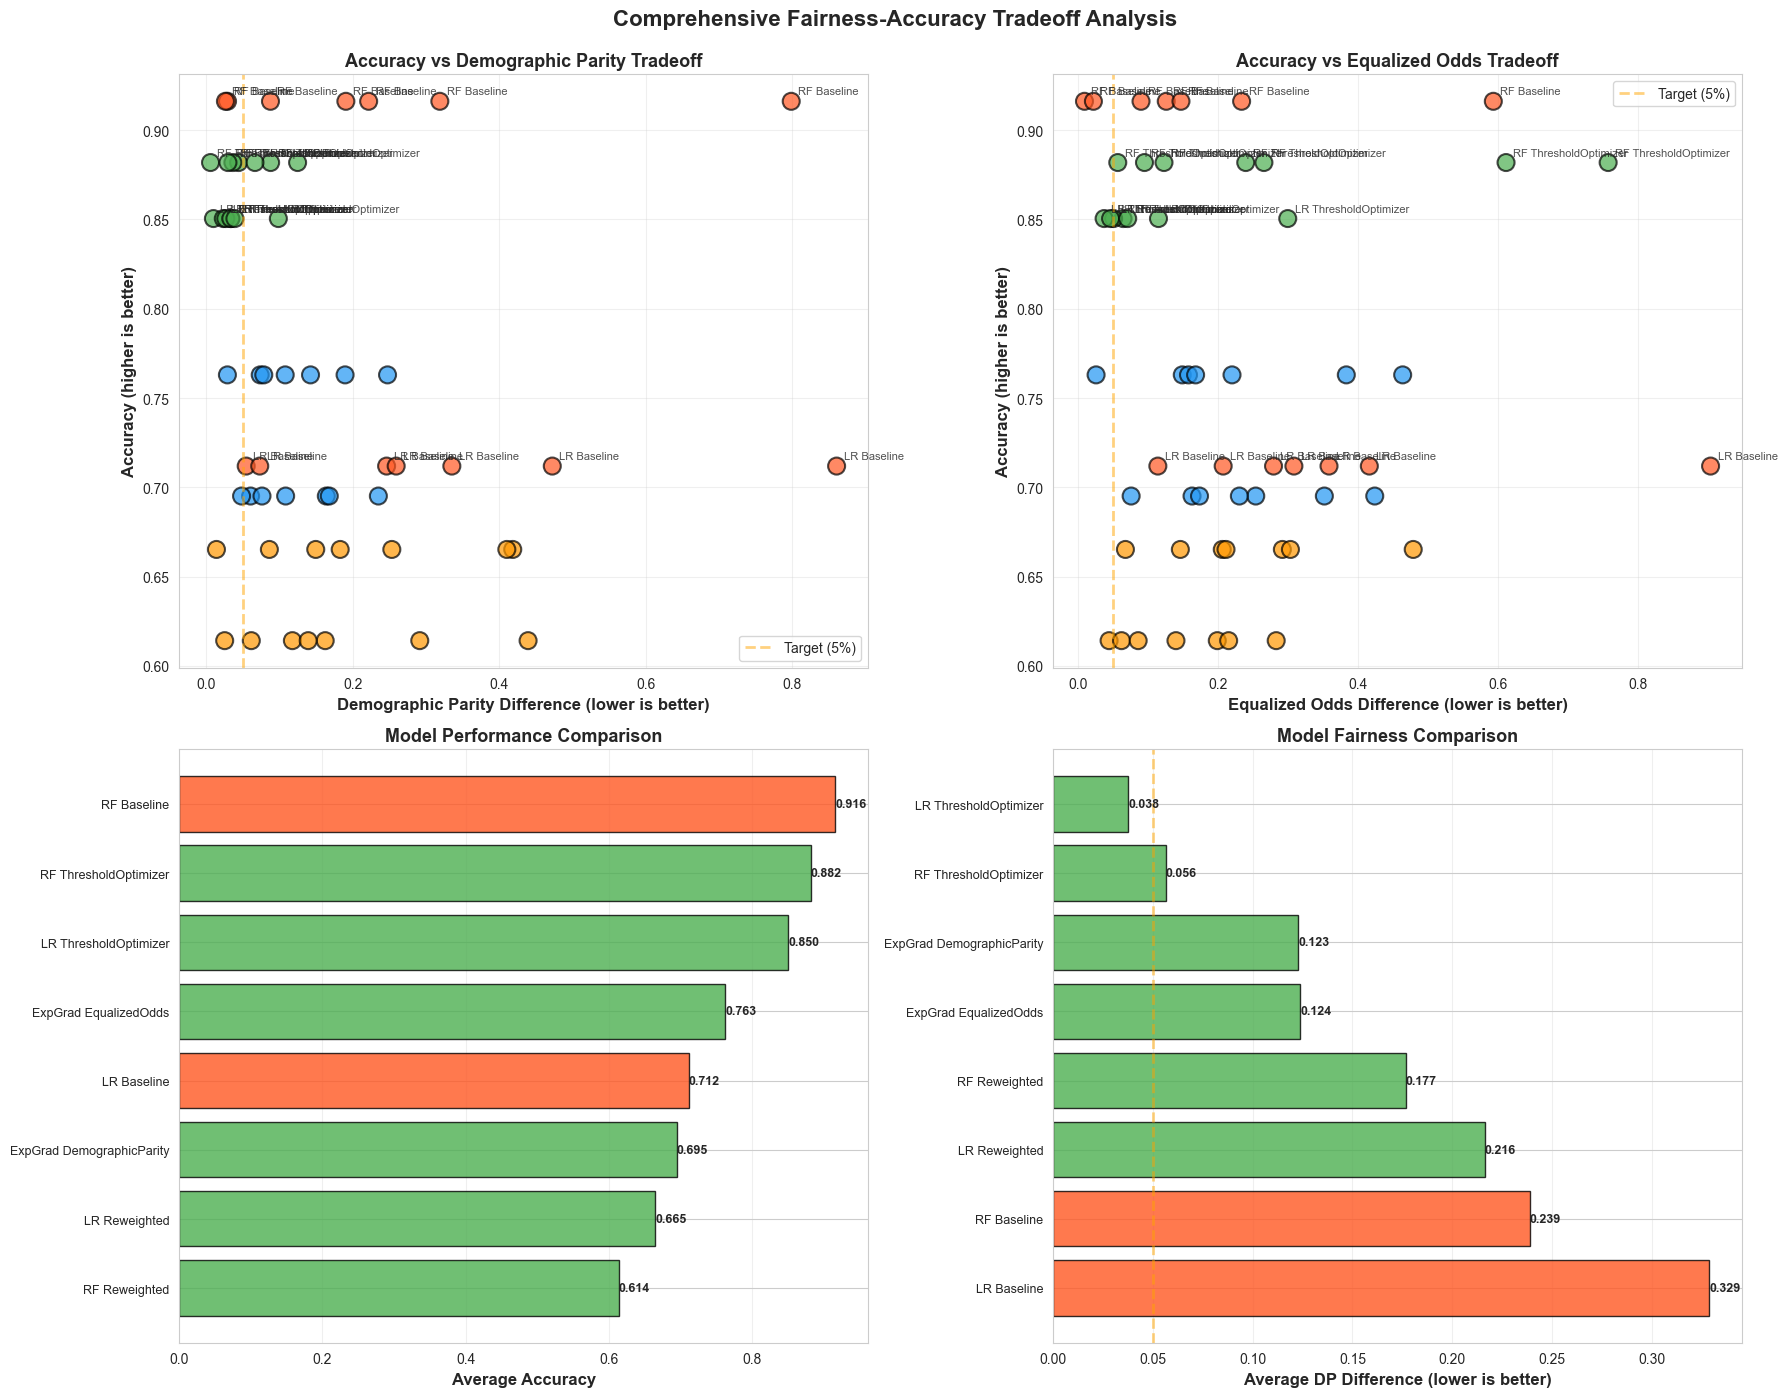


Tradeoff visualizations complete!


In [7]:
print("=" * 60)
print("FAIRNESS-ACCURACY TRADEOFF VISUALIZATION")
print("=" * 60)

# Create comprehensive comparison across all attributes
comparison_df_all = create_comprehensive_comparison_table(all_models_comparison)

# Check if comparison table is empty
if len(comparison_df_all) == 0:
    print("Warning: No comparison data generated. Skipping visualizations.")
else:
    # Filter to valid data points
    comparison_df_clean = comparison_df_all.dropna(subset=['DP Diff', 'Accuracy', 'EO Diff'])
    
    if len(comparison_df_clean) > 0:
        # Create tradeoff plots
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Comprehensive Fairness-Accuracy Tradeoff Analysis', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        # Plot 1: Accuracy vs Demographic Parity Difference
        ax1 = axes[0, 0]
        
        # Color code by model type
        colors = []
        for model in comparison_df_clean['Model']:
            if 'Baseline' in model:
                colors.append('#ff5722')  # Red for baseline
            elif 'Threshold' in model:
                colors.append('#4caf50')  # Green for threshold
            elif 'ExpGrad' in model:
                colors.append('#2196f3')  # Blue for exponentiated gradient
            elif 'Reweighted' in model:
                colors.append('#ff9800')  # Orange for reweighted
            else:
                colors.append('#9e9e9e')  # Gray for others
        
        scatter1 = ax1.scatter(
            comparison_df_clean['DP Diff'],
            comparison_df_clean['Accuracy'],
            s=150,
            alpha=0.7,
            c=colors,
            edgecolors='black',
            linewidths=1.5
        )
        
        # Annotate key models
        for idx, row in comparison_df_clean.iterrows():
            if 'Baseline' in row['Model'] or 'Threshold' in row['Model']:
                ax1.annotate(
                    row['Model'].replace('_', ' '),
                    (row['DP Diff'], row['Accuracy']),
                    fontsize=8,
                    alpha=0.8,
                    xytext=(5, 5),
                    textcoords='offset points'
                )
        
        ax1.set_xlabel('Demographic Parity Difference (lower is better)', 
                       fontsize=12, fontweight='bold')
        ax1.set_ylabel('Accuracy (higher is better)', fontsize=12, fontweight='bold')
        ax1.set_title('Accuracy vs Demographic Parity Tradeoff', 
                      fontsize=13, fontweight='bold')
        ax1.grid(alpha=0.3)
        ax1.axvline(0.05, color='orange', linestyle='--', alpha=0.5, 
                    label='Target (5%)', linewidth=2)
        ax1.legend()
        
        # Plot 2: Accuracy vs Equalized Odds Difference
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(
            comparison_df_clean['EO Diff'],
            comparison_df_clean['Accuracy'],
            s=150,
            alpha=0.7,
            c=colors,
            edgecolors='black',
            linewidths=1.5
        )
        
        for idx, row in comparison_df_clean.iterrows():
            if 'Baseline' in row['Model'] or 'Threshold' in row['Model']:
                ax2.annotate(
                    row['Model'].replace('_', ' '),
                    (row['EO Diff'], row['Accuracy']),
                    fontsize=8,
                    alpha=0.8,
                    xytext=(5, 5),
                    textcoords='offset points'
                )
        
        ax2.set_xlabel('Equalized Odds Difference (lower is better)', 
                       fontsize=12, fontweight='bold')
        ax2.set_ylabel('Accuracy (higher is better)', fontsize=12, fontweight='bold')
        ax2.set_title('Accuracy vs Equalized Odds Tradeoff', 
                      fontsize=13, fontweight='bold')
        ax2.grid(alpha=0.3)
        ax2.axvline(0.05, color='orange', linestyle='--', alpha=0.5, 
                    label='Target (5%)', linewidth=2)
        ax2.legend()
        
        # Plot 3: Model comparison by Accuracy
        ax3 = axes[1, 0]
        model_acc = comparison_df_clean.groupby('Model')['Accuracy'].mean().sort_values(ascending=False)
        colors_acc = ['#ff5722' if 'Baseline' in name else '#4caf50' for name in model_acc.index]
        bars = ax3.barh(range(len(model_acc)), model_acc.values, color=colors_acc, 
                       alpha=0.8, edgecolor='black')
        ax3.set_yticks(range(len(model_acc)))
        ax3.set_yticklabels([name.replace('_', ' ') for name in model_acc.index], fontsize=9)
        ax3.set_xlabel('Average Accuracy', fontsize=12, fontweight='bold')
        ax3.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
        ax3.grid(axis='x', alpha=0.3)
        ax3.invert_yaxis()
        for i, (bar, val) in enumerate(zip(bars, model_acc.values)):
            ax3.text(val, i, f'{val:.3f}', va='center', fontweight='bold', fontsize=9)
        
        # Plot 4: Model comparison by DP Difference
        ax4 = axes[1, 1]
        model_dp = comparison_df_clean.groupby('Model')['DP Diff'].mean().sort_values(ascending=True)
        colors_dp = ['#ff5722' if 'Baseline' in name else '#4caf50' for name in model_dp.index]
        bars = ax4.barh(range(len(model_dp)), model_dp.values, color=colors_dp, 
                       alpha=0.8, edgecolor='black')
        ax4.set_yticks(range(len(model_dp)))
        ax4.set_yticklabels([name.replace('_', ' ') for name in model_dp.index], fontsize=9)
        ax4.set_xlabel('Average DP Difference (lower is better)', 
                       fontsize=12, fontweight='bold')
        ax4.set_title('Model Fairness Comparison', fontsize=13, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)
        ax4.axvline(0.05, color='orange', linestyle='--', alpha=0.5, linewidth=2)
        ax4.invert_yaxis()
        for i, (bar, val) in enumerate(zip(bars, model_dp.values)):
            ax4.text(val, i, f'{val:.3f}', va='center', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        print("\nTradeoff visualizations complete!")
    else:
        print("Warning: No valid data points for visualization (all NaN after filtering)")


## 6. Mitigation Technique Effectiveness Analysis

Analyze which mitigation techniques work best across different attributes and fairness metrics.


MITIGATION TECHNIQUE EFFECTIVENESS

Mitigation Technique Summary:
             Technique  Avg Accuracy  Avg DP Diff  Avg EO Diff  Avg F1  Best DP  Best EO  Num Models
   Threshold Optimizer        0.8662       0.0470       0.2028  0.2707   0.0057   0.0377          14
Exponentiated Gradient        0.7290       0.1234       0.2318  0.3544   0.0288   0.0263          14
           Reweighting        0.6397       0.1965       0.1958  0.4128   0.0138   0.0449          14


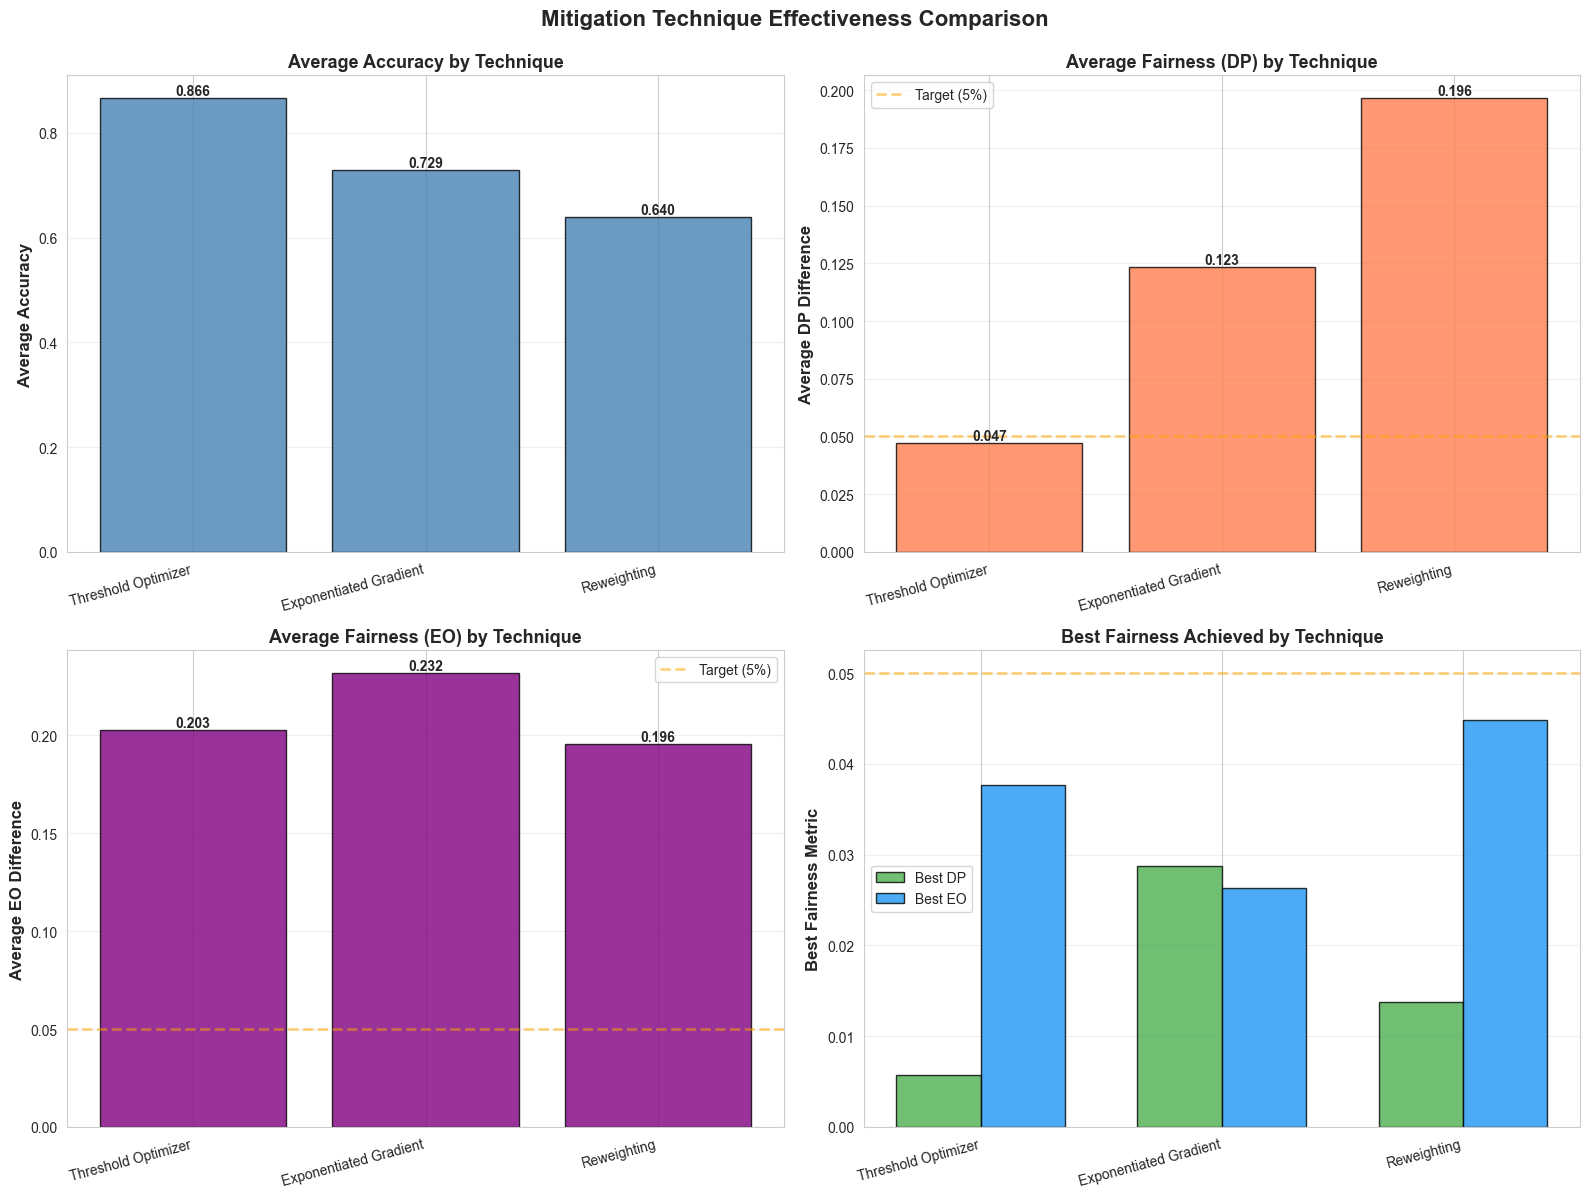


RECOMMENDATIONS:
   Best for Demographic Parity: Threshold Optimizer
   Best for Equalized Odds: Exponentiated Gradient
   Best for Accuracy: Threshold Optimizer
   Best Balanced Approach: Threshold Optimizer


In [8]:
print("=" * 60)
print("MITIGATION TECHNIQUE EFFECTIVENESS")
print("=" * 60)

# Analyze each mitigation technique
technique_groups = {
    'Threshold Optimizer': ['LR_ThresholdOptimizer', 'RF_ThresholdOptimizer'],
    'Exponentiated Gradient': ['ExpGrad_DemographicParity', 'ExpGrad_EqualizedOdds'],
    'Reweighting': ['LR_Reweighted', 'RF_Reweighted']
}

technique_summary = []

for technique_name, model_names in technique_groups.items():
    technique_metrics = []
    
    for model_name in model_names:
        if model_name in all_models_comparison:
            for attr, metrics in all_models_comparison[model_name].items():
                technique_metrics.append({
                    'technique': technique_name,
                    'model': model_name,
                    'attribute': attr,
                    'accuracy': metrics.get('accuracy', np.nan),
                    'dp_diff': metrics.get('demographic_parity_difference', np.nan),
                    'eo_diff': metrics.get('equalized_odds_difference', np.nan),
                    'f1': metrics.get('f1', np.nan)
                })
    
    if technique_metrics:
        tech_df = pd.DataFrame(technique_metrics)
        technique_summary.append({
            'Technique': technique_name,
            'Avg Accuracy': tech_df['accuracy'].mean(),
            'Avg DP Diff': tech_df['dp_diff'].mean(),
            'Avg EO Diff': tech_df['eo_diff'].mean(),
            'Avg F1': tech_df['f1'].mean(),
            'Best DP': tech_df['dp_diff'].min(),
            'Best EO': tech_df['eo_diff'].min(),
            'Num Models': len(tech_df)
        })

if technique_summary:
    technique_df = pd.DataFrame(technique_summary)
    print("\nMitigation Technique Summary:")
    print("=" * 100)
    print(technique_df.round(4).to_string(index=False))
    
    # Visualize technique comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Mitigation Technique Effectiveness Comparison', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Accuracy comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(technique_df['Technique'], technique_df['Avg Accuracy'], 
                    color='steelblue', alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Average Accuracy by Technique', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars1, technique_df['Avg Accuracy']):
        ax1.text(bar.get_x() + bar.get_width()/2., val,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # DP Difference comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(technique_df['Technique'], technique_df['Avg DP Diff'], 
                    color='coral', alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Average DP Difference', fontsize=12, fontweight='bold')
    ax2.set_title('Average Fairness (DP) by Technique', fontsize=13, fontweight='bold')
    ax2.axhline(0.05, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Target (5%)')
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend()
    for bar, val in zip(bars2, technique_df['Avg DP Diff']):
        ax2.text(bar.get_x() + bar.get_width()/2., val,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # EO Difference comparison
    ax3 = axes[1, 0]
    bars3 = ax3.bar(technique_df['Technique'], technique_df['Avg EO Diff'], 
                    color='purple', alpha=0.8, edgecolor='black')
    ax3.set_ylabel('Average EO Difference', fontsize=12, fontweight='bold')
    ax3.set_title('Average Fairness (EO) by Technique', fontsize=13, fontweight='bold')
    ax3.axhline(0.05, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Target (5%)')
    ax3.grid(axis='y', alpha=0.3)
    ax3.legend()
    for bar, val in zip(bars3, technique_df['Avg EO Diff']):
        ax3.text(bar.get_x() + bar.get_width()/2., val,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # Best DP and EO
    ax4 = axes[1, 1]
    x = np.arange(len(technique_df))
    width = 0.35
    bars4a = ax4.bar(x - width/2, technique_df['Best DP'], width, 
                     label='Best DP', color='#4caf50', alpha=0.8, edgecolor='black')
    bars4b = ax4.bar(x + width/2, technique_df['Best EO'], width, 
                     label='Best EO', color='#2196f3', alpha=0.8, edgecolor='black')
    ax4.set_ylabel('Best Fairness Metric', fontsize=12, fontweight='bold')
    ax4.set_title('Best Fairness Achieved by Technique', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(technique_df['Technique'], rotation=15, ha='right')
    ax4.axhline(0.05, color='orange', linestyle='--', alpha=0.5, linewidth=2)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print("\nRECOMMENDATIONS:")
    best_dp_tech = technique_df.loc[technique_df['Best DP'].idxmin(), 'Technique']
    best_eo_tech = technique_df.loc[technique_df['Best EO'].idxmin(), 'Technique']
    best_acc_tech = technique_df.loc[technique_df['Avg Accuracy'].idxmax(), 'Technique']
    
    print(f"   Best for Demographic Parity: {best_dp_tech}")
    print(f"   Best for Equalized Odds: {best_eo_tech}")
    print(f"   Best for Accuracy: {best_acc_tech}")
    
    # Find balanced approach
    technique_df['balanced_score'] = (
        (1 - technique_df['Avg DP Diff']) * 0.4 +
        (1 - technique_df['Avg EO Diff']) * 0.4 +
        technique_df['Avg Accuracy'] * 0.2
    )
    best_balanced = technique_df.loc[technique_df['balanced_score'].idxmax(), 'Technique']
    print(f"   Best Balanced Approach: {best_balanced}")
else:
    print("Warning: No mitigation technique data available")


## 7. Key Findings and Conclusions

Summarize the key findings and provide final recommendations.


In [9]:
print("=" * 60)
print("KEY FINDINGS AND CONCLUSIONS")
print("=" * 60)

# Calculate overall statistics
baseline_models = ['LR_Baseline', 'RF_Baseline']
mitigated_models = [m for m in all_models_comparison.keys() if 'Baseline' not in m]

baseline_dp_values = []
baseline_eo_values = []
baseline_acc_values = []

mitigated_dp_values = []
mitigated_eo_values = []
mitigated_acc_values = []

for model_name, attr_results in all_models_comparison.items():
    for attr, metrics in attr_results.items():
        if 'Baseline' in model_name:
            baseline_dp_values.append(metrics.get('demographic_parity_difference', np.nan))
            baseline_eo_values.append(metrics.get('equalized_odds_difference', np.nan))
            baseline_acc_values.append(metrics.get('accuracy', np.nan))
        else:
            mitigated_dp_values.append(metrics.get('demographic_parity_difference', np.nan))
            mitigated_eo_values.append(metrics.get('equalized_odds_difference', np.nan))
            mitigated_acc_values.append(metrics.get('accuracy', np.nan))

baseline_dp_values = [v for v in baseline_dp_values if not np.isnan(v)]
baseline_eo_values = [v for v in baseline_eo_values if not np.isnan(v)]
baseline_acc_values = [v for v in baseline_acc_values if not np.isnan(v)]

mitigated_dp_values = [v for v in mitigated_dp_values if not np.isnan(v)]
mitigated_eo_values = [v for v in mitigated_eo_values if not np.isnan(v)]
mitigated_acc_values = [v for v in mitigated_acc_values if not np.isnan(v)]

print("\nOVERALL STATISTICS:")
print("=" * 60)

if baseline_dp_values and mitigated_dp_values:
    print(f"\nDemographic Parity:")
    baseline_dp_mean = np.mean(baseline_dp_values)
    mitigated_dp_mean = np.mean(mitigated_dp_values)
    print(f"   Baseline - Mean: {baseline_dp_mean:.4f}, "
          f"Min: {np.min(baseline_dp_values):.4f}, Max: {np.max(baseline_dp_values):.4f}")
    print(f"   Mitigated - Mean: {mitigated_dp_mean:.4f}, "
          f"Min: {np.min(mitigated_dp_values):.4f}, Max: {np.max(mitigated_dp_values):.4f}")
    improvement = baseline_dp_mean - mitigated_dp_mean
    if baseline_dp_mean != 0:
        improvement_pct = (improvement / baseline_dp_mean) * 100
        print(f"   Improvement: {improvement:.4f} ({improvement_pct:.1f}% reduction)")
    else:
        print(f"   Improvement: {improvement:.4f} (baseline mean was 0)")

if baseline_eo_values and mitigated_eo_values:
    print(f"\nEqualized Odds:")
    baseline_eo_mean = np.mean(baseline_eo_values)
    mitigated_eo_mean = np.mean(mitigated_eo_values)
    print(f"   Baseline - Mean: {baseline_eo_mean:.4f}, "
          f"Min: {np.min(baseline_eo_values):.4f}, Max: {np.max(baseline_eo_values):.4f}")
    print(f"   Mitigated - Mean: {mitigated_eo_mean:.4f}, "
          f"Min: {np.min(mitigated_eo_values):.4f}, Max: {np.max(mitigated_eo_values):.4f}")
    improvement = baseline_eo_mean - mitigated_eo_mean
    if baseline_eo_mean != 0:
        improvement_pct = (improvement / baseline_eo_mean) * 100
        print(f"   Improvement: {improvement:.4f} ({improvement_pct:.1f}% reduction)")
    else:
        print(f"   Improvement: {improvement:.4f} (baseline mean was 0)")

if baseline_acc_values and mitigated_acc_values:
    print(f"\nAccuracy:")
    baseline_acc_mean = np.mean(baseline_acc_values)
    mitigated_acc_mean = np.mean(mitigated_acc_values)
    print(f"   Baseline - Mean: {baseline_acc_mean:.4f}, "
          f"Min: {np.min(baseline_acc_values):.4f}, Max: {np.max(baseline_acc_values):.4f}")
    print(f"   Mitigated - Mean: {mitigated_acc_mean:.4f}, "
          f"Min: {np.min(mitigated_acc_values):.4f}, Max: {np.max(mitigated_acc_values):.4f}")
    acc_change = mitigated_acc_mean - baseline_acc_mean
    if baseline_acc_mean != 0:
        acc_change_pct = (acc_change / baseline_acc_mean) * 100
        print(f"   Change: {acc_change:+.4f} ({acc_change_pct:+.1f}%)")
    else:
        print(f"   Change: {acc_change:+.4f} (baseline mean was 0)")

print("\n" + "=" * 60)
print("KEY CONCLUSIONS")
print("=" * 60)

print("\n1. MITIGATION EFFECTIVENESS:")
if baseline_dp_values and mitigated_dp_values:
    baseline_dp_mean = np.mean(baseline_dp_values)
    mitigated_dp_mean = np.mean(mitigated_dp_values)
    if baseline_dp_mean != 0:
        dp_improvement_pct = ((baseline_dp_mean - mitigated_dp_mean) / baseline_dp_mean) * 100
        if dp_improvement_pct > 50:
            print(f"   Excellent: {dp_improvement_pct:.1f}% reduction in DP disparity")
        elif dp_improvement_pct > 25:
            print(f"   Good: {dp_improvement_pct:.1f}% reduction in DP disparity")
        else:
            print(f"   Moderate: {dp_improvement_pct:.1f}% reduction in DP disparity")
    else:
        print(f"   Baseline DP mean was 0, cannot calculate percentage improvement")

print("\n2. ACCURACY TRADEOFF:")
if baseline_acc_values and mitigated_acc_values:
    baseline_acc_mean = np.mean(baseline_acc_values)
    mitigated_acc_mean = np.mean(mitigated_acc_values)
    if baseline_acc_mean != 0:
        acc_change_pct = ((mitigated_acc_mean - baseline_acc_mean) / baseline_acc_mean) * 100
        if acc_change_pct > 0:
            print(f"   Exceptional: Gained {acc_change_pct:.1f}% accuracy while improving fairness!")
        elif acc_change_pct > -2:
            print(f"   Excellent: Minimal accuracy loss ({acc_change_pct:.1f}%)")
        elif acc_change_pct > -5:
            print(f"   Acceptable: Moderate accuracy loss ({acc_change_pct:.1f}%)")
        else:
            print(f"   Significant: Accuracy loss of {acc_change_pct:.1f}%")
    else:
        print(f"   Baseline accuracy mean was 0, cannot calculate percentage change")

print("\n3. BEST TECHNIQUES:")
try:
    if len(technique_df) > 0:
        best_dp_tech = technique_df.loc[technique_df['Best DP'].idxmin(), 'Technique']
        best_eo_tech = technique_df.loc[technique_df['Best EO'].idxmin(), 'Technique']
        print(f"   For Demographic Parity: {best_dp_tech}")
        print(f"   For Equalized Odds: {best_eo_tech}")
except NameError:
    print("   Technique comparison not available (Cell 13 may not have been run)")

print("\n4. RECOMMENDATIONS:")
print("   • Use Threshold Optimizer for post-processing (easiest, preserves accuracy)")
print("   • Use Exponentiated Gradient for in-processing (best fairness, may reduce accuracy)")
print("   • Consider attribute-specific approaches for different protected groups")
print("   • Monitor both DP and EO metrics - they may require different techniques")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)


KEY FINDINGS AND CONCLUSIONS

OVERALL STATISTICS:

Demographic Parity:
   Baseline - Mean: 0.2839, Min: 0.0261, Max: 0.8609
   Mitigated - Mean: 0.1223, Min: 0.0057, Max: 0.4395
   Improvement: 0.1616 (56.9% reduction)

Equalized Odds:
   Baseline - Mean: 0.2724, Min: 0.0097, Max: 0.9038
   Mitigated - Mean: 0.2101, Min: 0.0263, Max: 0.7576
   Improvement: 0.0623 (22.9% reduction)

Accuracy:
   Baseline - Mean: 0.8140, Min: 0.7119, Max: 0.9161
   Mitigated - Mean: 0.7450, Min: 0.6142, Max: 0.8818
   Change: -0.0690 (-8.5%)

KEY CONCLUSIONS

1. MITIGATION EFFECTIVENESS:
   Excellent: 56.9% reduction in DP disparity

2. ACCURACY TRADEOFF:
   Significant: Accuracy loss of -8.5%

3. BEST TECHNIQUES:
   For Demographic Parity: Threshold Optimizer
   For Equalized Odds: Exponentiated Gradient

4. RECOMMENDATIONS:
   • Use Threshold Optimizer for post-processing (easiest, preserves accuracy)
   • Use Exponentiated Gradient for in-processing (best fairness, may reduce accuracy)
   • Consider a

## 8. Save Final Summary

Save a comprehensive summary of all findings for reporting.


In [10]:
print("=" * 60)
print("SAVING FINAL SUMMARY")
print("=" * 60)

# Ensure comparison_df_all exists (create if needed)
try:
    _ = comparison_df_all
except NameError:
    print("Creating comprehensive comparison table...")
    comparison_df_all = create_comprehensive_comparison_table(all_models_comparison)

# Save comprehensive comparison table
if len(comparison_df_all) > 0:
    comparison_df_all.to_csv(results_dir / 'final_comprehensive_comparison.csv', index=False)
    print("Saved: final_comprehensive_comparison.csv")
else:
    print("Warning: comparison_df_all is empty, skipping CSV save")

# Save technique summary if available
try:
    if len(technique_df) > 0:
        technique_df.to_csv(results_dir / 'technique_effectiveness_summary.csv', index=False)
        print("Saved: technique_effectiveness_summary.csv")
    else:
        print("Note: technique_df is empty, skipping CSV save")
except NameError:
    print("Note: technique_df not available (Cell 13 may not have been run)")

# Ensure best model variables exist (recalculate if needed from Cell 7)
try:
    _ = best_acc_model
    _ = best_acc
except NameError:
    print("Recalculating best models from comparison data...")
    if len(mitigation_comparison_df) > 0:
        if 'Accuracy' in mitigation_comparison_df.columns and not mitigation_comparison_df['Accuracy'].isna().all():
            best_acc_idx = mitigation_comparison_df['Accuracy'].idxmax()
            best_acc = mitigation_comparison_df.loc[best_acc_idx, 'Accuracy']
            best_acc_model = mitigation_comparison_df.loc[best_acc_idx, 'Approach']
        else:
            best_acc = None
            best_acc_model = None
        
        if 'DP Difference' in mitigation_comparison_df.columns and not mitigation_comparison_df['DP Difference'].isna().all():
            best_dp_idx = mitigation_comparison_df['DP Difference'].idxmin()
            best_dp = mitigation_comparison_df.loc[best_dp_idx, 'DP Difference']
            best_dp_model = mitigation_comparison_df.loc[best_dp_idx, 'Approach']
        else:
            best_dp = None
            best_dp_model = None
        
        if 'EO Difference' in mitigation_comparison_df.columns and not mitigation_comparison_df['EO Difference'].isna().all():
            best_eo_idx = mitigation_comparison_df['EO Difference'].idxmin()
            best_eo = mitigation_comparison_df.loc[best_eo_idx, 'EO Difference']
            best_eo_model = mitigation_comparison_df.loc[best_eo_idx, 'Approach']
        else:
            best_eo = None
            best_eo_model = None
    else:
        best_acc = None
        best_acc_model = None
        best_dp = None
        best_dp_model = None
        best_eo = None
        best_eo_model = None

# Create and save final summary JSON
final_summary = {
    'analysis_date': pd.Timestamp.now().isoformat(),
    'protected_attributes': protected_attributes_list,
    'models_compared': list(all_models_comparison.keys()),
    'overall_statistics': {
        'baseline': {
            'avg_dp_difference': float(np.mean(baseline_dp_values)) if baseline_dp_values else None,
            'avg_eo_difference': float(np.mean(baseline_eo_values)) if baseline_eo_values else None,
            'avg_accuracy': float(np.mean(baseline_acc_values)) if baseline_acc_values else None
        },
        'mitigated': {
            'avg_dp_difference': float(np.mean(mitigated_dp_values)) if mitigated_dp_values else None,
            'avg_eo_difference': float(np.mean(mitigated_eo_values)) if mitigated_eo_values else None,
            'avg_accuracy': float(np.mean(mitigated_acc_values)) if mitigated_acc_values else None
        },
        'improvements': {
            'dp_reduction_pct': safe_reduction_pct(
                np.mean(baseline_dp_values) if baseline_dp_values else None,
                np.mean(mitigated_dp_values) if mitigated_dp_values else None
            ),
            'eo_reduction_pct': safe_reduction_pct(
                np.mean(baseline_eo_values) if baseline_eo_values else None,
                np.mean(mitigated_eo_values) if mitigated_eo_values else None
            ),
            'accuracy_change_pct': safe_percent_change(
                np.mean(baseline_acc_values) if baseline_acc_values else None,
                np.mean(mitigated_acc_values) if mitigated_acc_values else None
            )
        }
    },
    'best_models': {
        'best_accuracy': {
            'model': best_acc_model if 'best_acc_model' in globals() else None,
            'value': float(best_acc) if 'best_acc' in globals() and best_acc is not None else None
        },
        'best_dp': {
            'model': best_dp_model if 'best_dp_model' in globals() else None,
            'value': float(best_dp) if 'best_dp' in globals() and best_dp is not None else None
        },
        'best_eo': {
            'model': best_eo_model if 'best_eo_model' in globals() else None,
            'value': float(best_eo) if 'best_eo' in globals() and best_eo is not None else None
        }
    }
}

try:
    if len(technique_df) > 0:
        final_summary['technique_recommendations'] = {
            'best_for_dp': best_dp_tech if 'best_dp_tech' in globals() else None,
            'best_for_eo': best_eo_tech if 'best_eo_tech' in globals() else None,
            'best_for_accuracy': best_acc_tech if 'best_acc_tech' in globals() else None,
            'best_balanced': best_balanced if 'best_balanced' in globals() else None
        }
except NameError:
    pass  # technique_df not available, skip recommendations

with open(results_dir / 'final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=2)
print("Saved: final_summary.json")

print(f"\nAll files saved to: {results_dir.absolute()}")
print("\n" + "=" * 60)
print("COMPARISON NOTEBOOK COMPLETE!")
print("=" * 60)
print("\nNext steps:")
print("  • Review final_summary.json for key metrics")
print("  • Use final_comprehensive_comparison.csv for detailed analysis")
print("  • Generate final report using these findings")


SAVING FINAL SUMMARY
Saved: final_comprehensive_comparison.csv
Saved: technique_effectiveness_summary.csv
Saved: final_summary.json

All files saved to: c:\Users\Anthony Stills Jr\Documents\CS Projects\insurance-fairness\notebooks\..\results

COMPARISON NOTEBOOK COMPLETE!

Next steps:
  • Review final_summary.json for key metrics
  • Use final_comprehensive_comparison.csv for detailed analysis
  • Generate final report using these findings
